In [1]:
###### 调用相关库 #######
import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
#from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os 
import warnings
warnings.filterwarnings('ignore')

os.environ['CUDA_VISIBLE_DEVICES'] = "0" 
np.random.seed(0)#12345,1234,12
tf.random.set_random_seed(0)

2024-06-11 11:10:05.801182: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:

class PhysicsInformedNN:
    it = 0
    
    # def __init__(self, X_u, u, X_f, layers,lb, ub,vf,rho_j,v_lb,v_ub,rho_lb,rho_ub):
    def __init__(self, X_u, u, X_f, layers,lb, ub,vf,rho_j):
        self.vf = vf
        self.rho_j = rho_j
        self.lb = lb
        self.ub = ub
        # self.v_lb = v_lb
        # self.v_ub = v_ub
        # self.rho_lb = rho_lb
        # self.rho_ub = rho_ub
    
        self.x_u = X_u[:,0:1]
        self.t_u = X_u[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.v = u[:,0:1]
        self.rho = u[:,1:2]
        
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x_u_tf = tf.placeholder(tf.float32, shape=[None, self.x_u.shape[1]])
        self.t_u_tf = tf.placeholder(tf.float32, shape=[None, self.t_u.shape[1]])        
        self.v_tf = tf.placeholder(tf.float32, shape=[None, self.v.shape[1]])
        self.rho_tf = tf.placeholder(tf.float32, shape=[None, self.rho.shape[1]])
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])        
                
        self.v_pred, self.rho_pred = self.net_u(self.x_u_tf, self.t_u_tf) 
        self.f_pde, self.f_fd, self.f_loss = self.net_f(self.x_f_tf, self.t_f_tf) 
        
        self.loss = 0.4 * tf.reduce_mean(tf.square(self.v_tf - self.v_pred)) + 0.6 * tf.reduce_mean(tf.square(self.rho_tf - self.rho_pred)) +\
                         0.5* tf.reduce_mean(tf.square(self.f_pde)) + 0.5 *  tf.reduce_mean(tf.square(self.f_fd)) 
        # + 0.5 *  tf.reduce_mean(tf.square(self.f_loss))
                         
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
        
        self.optimizer_Adam = tf.train.AdamOptimizer(0.001)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):  
        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0, num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0         # scaling
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        
        return Y
            
    def net_u(self, x, t):
        
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        v = u[:,0:1]
        rho = u[:,1:2]
        return v,rho
    
    def net_f(self, x,t):
        v,rho = self.net_u(x,t)
        # v = v * (v_ub-v_lb) + v_lb
        # rho = rho * (rho_ub-rho_lb) + rho_lb
        rho_t = tf.gradients(rho, t)[0] 
        rho_x = tf.gradients(rho, x)[0]
        v_x = tf.gradients(v, x)[0]
        f_pde = rho_t + rho * v_x + v * rho_x       #LWR的loss
        f_fd = self.vf * tf.exp(-rho/self.rho_j)-v  #基本图loss
        
        fd = self.vf * tf.exp(-rho/self.rho_j)     
        f_pde_2 = v + vf- fd     
        f_pde_3 = fd - v
        f_pde_2_t = tf.gradients(f_pde_2, t)[0]    
        f_pde_2_x = tf.gradients(f_pde_2, x)[0] 
        f_loss = f_pde_2_t + v * f_pde_2_x - (f_pde_3)/30   #二阶ARZ
        return f_pde, f_fd, f_loss

    
    def callback(self, loss):
        print('Loss:', loss)
        
    def train(self,nIter):     
        
        tf_dict = {self.x_u_tf: self.x_u, self.t_u_tf: self.t_u, self.v_tf: self.v,self.rho_tf: self.rho,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}   
        
        start_time = time.time()
        MSE_history=[]
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            if it %100 == 0:
#                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e' % 
                      (it, loss_value))
#                start_time = time.time()
                MSE_history.append(loss_value)
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
        return MSE_history
    
    def predict(self, X_star):      
       
        # u_star = self.sess.run(self.u_pred, {self.x_u_tf: X_star[:,0:1], self.t_u_tf: X_star[:,1:2]}) 
        # f_star = self.sess.run(self.f_pred, {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]})   
        
        v_star = self.sess.run(self.v_pred, {self.x_u_tf: X_star[:,0:1], self.t_u_tf: X_star[:,1:2]})  
        rho_star = self.sess.run(self.rho_pred, {self.x_u_tf: X_star[:,0:1], self.t_u_tf: X_star[:,1:2]})  
                
        f_v_star = self.sess.run(self.f_pde, {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]})
        f_rho_star = self.sess.run(self.f_fd, {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]})
        
        return v_star, rho_star

In [3]:
if __name__ == "__main__": 
    layers = [2, 64, 64, 64, 64, 64, 64, 64, 64, 64, 2] #######
    
    import pickle
    # 读取pkl文件,rb是读取二进制文件，而r是读取文本文件
    file = open('US101_Lane1to5_t1.5s30.pickle', 'rb')
    info = pickle.load(file)
    speed=info['vMat'].T
    density = info['rhoMat'].T
    flat_arrayv = speed.flatten()
    flat_arrayrho = density.flatten()
    # v_lb,v_ub,rho_lb,rho_ub = min(flat_arrayv),max(flat_arrayv),min(flat_arrayrho),max(flat_arrayrho)
    # flat_array1 = (flat_arrayv-v_lb)/(v_ub-v_lb)
    # flat_array2 = (flat_arrayrho-rho_lb)/(rho_ub-rho_lb)
    
    t=info['t']
    x=info['s']
    X, T = np.meshgrid(x,t)
    # 创建DataFrame
    df = pd.DataFrame({'speed': flat_arrayv, 'density': flat_arrayrho,'x':x * 1770})
    # ------------- alpha = 0.01 --------------
    vf = 26.5932
    rho_j = 0.3008
    # ---------------------------
    # ------------- alpha = 0.08 --------------
    # vf = 25.1762
    # rho_j = 0.2663
    # ---------------------------
     # ------------- alpha = 0.15 --------------
    # vf = 24.8948
    # rho_j = 0.2491
    # ---------------------------
     # ------------- alpha = 0.22 --------------
    # vf = 24.6698
    # rho_j = 0.2386
    # ---------------------------
    # ------------- alpha = 0.29 --------------
    # vf = 24.4427
    # rho_j = 0.2314
    # ---------------------------
    # ------------- alpha = 0.36 --------------
    # vf = 24.2222
    # rho_j = 0.2256
    # ---------------------------
    # ------------- alpha = 0.43 --------------
    # vf = 24.0017
    # rho_j = 0.2207
    # ---------------------------
    # ------------- alpha = 0.50 --------------
    # vf = 23.7619
    # rho_j = 0.2164
    # ---------------------------
    # # ------------- alpha = 0.57 --------------
    # vf = 23.4925
    # rho_j = 0.2125
    # # ---------------------------
    # ------------- alpha = 0.64 --------------
    # vf = 23.1839
    # rho_j = 0.2089
    # # ---------------------------
    # ------------- alpha = 0.71 --------------
    # vf = 22.8114
    # rho_j = 0.2053
    # # ---------------------------
    # ------------- alpha = 0.78 --------------
    # vf = 22.3361
    # rho_j = 0.2018
    # # ---------------------------
    # ------------- alpha = 0.85 --------------
    # vf = 21.7062
    # rho_j = 0.1977
    # # ---------------------------
    # ------------- alpha = 0.92 --------------
    # vf = 20.6696
    # rho_j = 0.1926
    # # ---------------------------
    # ------------- alpha = 0.99 --------------
    # vf = 15.7383
    # rho_j = 0.1892
    # # ---------------------------
    
    
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_star = df.loc[:,['speed','density']]
    
    u_star = np.array(u_star.iloc[:,:])              
    
    
    # Doman bounds
    lb = X_star.min(0)
    ub = X_star.max(0)  
    
   # ------更换传感器数量m：4,6,9

    m = 12
    if m == 12:
        loopidx = [0,1,2,4,6,8,10,12,14,16,18,20]
    else:
        gap = int(len(x)/(m-1))
        loopidx = [i*gap for i in range(m-1)]
        loopidx.append(len(x)-1)
    span = np.array(loopidx)
    X_u_train = np.hstack([np.meshgrid(np.array(x)[span],t)[0].reshape(-1,1), np.meshgrid(np.array(x)[span],t)[1].reshape(-1,1) ])
    u_train = df[df['x'].isin(df.loc[span,:]['x'])].loc[:,['speed','density']]
    u_train = np.array(u_train.iloc[:,:])
    idx2 = np.random.choice(X_star.shape[0], int(X_star.shape[0] * 0.6), replace=False)
    X_f_train = X_star[idx2,:]
    # X_f_train = lb + (ub-lb)*lhs(2, N_f)
    # X_f_train = np.vstack((X_f_train, X_u_train))
    data_list = [[] for i in range(2)]
    X_u_train = X_u_train[:, :]
    u_train = u_train[:,:]

    # model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers,lb, ub,vf,rho_j,v_lb,v_ub,rho_lb,rho_ub)
    model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers,lb, ub,vf,rho_j)
    start_time = time.time()                
    model.train(20000)
    elapsed = time.time() - start_time                
    print('Training time: %.4f' % (elapsed))

    v_pred, rho_pred = model.predict(X_star)
    print(v_pred)
    print(flat_arrayv)
    # v_pred = v_pred * (v_ub-v_lb) + v_lb
    # rho_pred = rho_pred * (rho_ub-rho_lb) + rho_lb

    error_v = np.linalg.norm(flat_arrayv-v_pred.flatten(),2)/np.linalg.norm(flat_arrayv,2)
    # print('Error v: %e' % (error_v))    
    
    error_rho = np.linalg.norm(flat_arrayrho-rho_pred.flatten(),2)/np.linalg.norm(flat_arrayrho,2)
    # print('Error rho: %e' % (error_rho))  


2024-06-11 11:10:07.261092: I tensorflow/core/platform/cpu_feature_guard.cc:145] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX
2024-06-11 11:10:07.270561: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2400000000 Hz
2024-06-11 11:10:07.272864: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5556f5b8b860 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-06-11 11:10:07.272901: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-06-11 11:10:07.275272: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-06-11 11:10:07.366191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1666] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3080 Ti major: 8 minor: 6 memoryClockRate(GHz): 1.665
pciBusID: 0000:d9:00.0
2024-06-11 11:10:0

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:d9:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device




2024-06-11 11:10:07.860727: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1206] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-06-11 11:10:07.860755: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1212]      0 
2024-06-11 11:10:07.860759: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1225] 0:   N 
2024-06-11 11:10:07.861614: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1351] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 9871 MB memory) -> physical GPU (device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:d9:00.0, compute capability: 8.6)
2024-06-11 11:10:07.863774: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55571d51a7b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-11 11:10:07.863787: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:d9:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:GPU:0
truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
truncated_normal: (Add): /job:localhost/replica:0/task:0/device:GPU:0
Variable: (VariableV2): /job:localhost/replica:0/task:0/device:GPU:0
Variable/Assign: (Assign): /job:localhost/replica:0/task:0/device:GPU:0
Variable/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
Variable_1: (VariableV2): /job:localhost/replica:0/task:0/device:GPU:0
Variable_1/Assign: (Assign): /job:localhost/replica:0/task:0/device:GPU:0
Variable_1/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
truncated_normal_

2024-06-11 11:10:10.373036: I tensorflow/core/common_runtime/placer.cc:54] truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-11 11:10:10.373078: I tensorflow/core/common_runtime/placer.cc:54] truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-11 11:10:10.373084: I tensorflow/core/common_runtime/placer.cc:54] truncated_normal: (Add): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-11 11:10:10.373089: I tensorflow/core/common_runtime/placer.cc:54] Variable: (VariableV2): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-11 11:10:10.373096: I tensorflow/core/common_runtime/placer.cc:54] Variable/Assign: (Assign): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-11 11:10:10.373099: I tensorflow/core/common_runtime/placer.cc:54] Variable/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-11 11:10:10.373103: I tensorflow/core/common_runtime/placer.cc:54] Variable_1: (Variabl

It: 0, Loss: 3.522e+02
It: 100, Loss: 7.281e+00
It: 200, Loss: 4.931e+00
It: 300, Loss: 4.641e+00
It: 400, Loss: 4.432e+00
It: 500, Loss: 4.296e+00
It: 600, Loss: 4.157e+00
It: 700, Loss: 4.072e+00
It: 800, Loss: 4.014e+00
It: 900, Loss: 3.939e+00
It: 1000, Loss: 3.792e+00
It: 1100, Loss: 3.556e+00
It: 1200, Loss: 3.430e+00
It: 1300, Loss: 3.700e+00
It: 1400, Loss: 3.403e+00
It: 1500, Loss: 3.368e+00
It: 1600, Loss: 3.351e+00
It: 1700, Loss: 3.341e+00
It: 1800, Loss: 3.333e+00
It: 1900, Loss: 3.327e+00
It: 2000, Loss: 3.320e+00
It: 2100, Loss: 3.314e+00
It: 2200, Loss: 3.314e+00
It: 2300, Loss: 3.301e+00
It: 2400, Loss: 3.299e+00
It: 2500, Loss: 3.287e+00
It: 2600, Loss: 3.282e+00
It: 2700, Loss: 3.271e+00
It: 2800, Loss: 3.258e+00
It: 2900, Loss: 3.263e+00
It: 3000, Loss: 3.243e+00
It: 3100, Loss: 3.241e+00
It: 3200, Loss: 3.234e+00
It: 3300, Loss: 3.222e+00
It: 3400, Loss: 3.216e+00
It: 3500, Loss: 3.231e+00
It: 3600, Loss: 3.198e+00
It: 3700, Loss: 3.170e+00
It: 3800, Loss: 3.145e+0

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.215709
  Number of iterations: 14
  Number of functions evaluations: 31


Training time: 271.5107
[[10.411595 ]
 [11.24981  ]
 [12.117841 ]
 ...
 [ 7.784387 ]
 [ 7.089398 ]
 [ 6.4740334]]
[10.517886   10.82187587 11.7201514  ...  6.66410876  5.76945211
  6.93174673]


In [4]:
v_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')
rho_pred = griddata(X_star, rho_pred.flatten(), (X, T), method='cubic')
path= r'/root/autodl-tmp/LWR12loops'
import os
np.save(os.path.join(path,'v_alpha'+ str(0.01) + '_lwr_loop'+str(m) + '.npy'),arr=v_pred)#######
np.save(os.path.join(path,'rho_alpha'+ str(0.01) + '_lwr_loop'+str(m) + '.npy'),arr=rho_pred)#######

In [5]:
import numpy as np
import matplotlib as mpl
#mpl.use('pgf')

def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(1.0),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
#mpl.rcParams.update(pgf_with_latex)

import matplotlib.pyplot as plt

# I make my own newfig and savefig functions
def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename, crop = True):
    if crop == True:
#        plt.savefig('{}.pgf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.pdf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.eps'.format(filename), bbox_inches='tight', pad_inches=0)
    else:
#        plt.savefig('{}.pgf'.format(filename))
        plt.savefig('{}.pdf'.format(filename))
        plt.savefig('{}.eps'.format(filename))

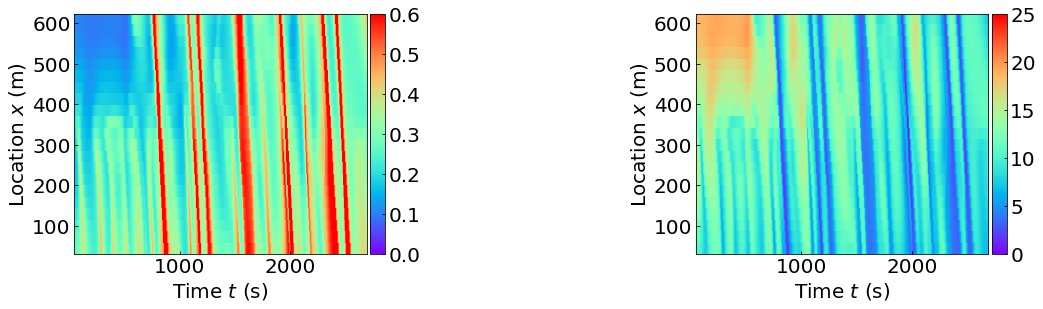

In [6]:
plt.rcParams['xtick.direction'] = 'in'#将x周的刻度线方向设置向内
plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内
fig, ax = newfig(4,2)
ax.axis('off')

####### Row 1: PIDL: u(t,x) ##################  


gs0 = gridspec.GridSpec(4, 2)
gs0.update(top=1, bottom=7/8, left=0.2, right=0.4, wspace=0)
ax = plt.subplot(gs0[:, :])
ax.tick_params(axis='both', which='major', labelsize=20)

h = ax.imshow(rho_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[min(t), max(t), min(x), max(x)],vmin = 0, vmax = 0.6,
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cax.tick_params(labelsize=20)
fig.colorbar(h, cax=cax)
# ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', markersize = 2, clip_on = False)
# ax.set_ylim(0, 65)
# ax.set_yticks([0,20,40,60])
# ax.set_xlim([0, 516])
# ax.set_xticks([0,100,200,300,400,500])
# ax.set_xticklabels(labels=[0,100,200,300,400,500], rotation=90)  # 旋转90度
ax.set_xlabel('Time $t$ (s)', fontsize = 20)
ax.set_ylabel('Location $x$ (m)', fontsize = 20)
# ax.legend(frameon=False, loc = 'best', fontsize = 20)
# ax.set_title('4_loop $v(x,t)$ (m./s)', fontsize = 20,pad=20)


####### Row 2: PIDL: u(t,x) ##################  
gs0 = gridspec.GridSpec(4, 2)
gs0.update(top=1, bottom=7/8, left=0.6, right=0.8, wspace=0)
ax = plt.subplot(gs0[:, :])
ax.tick_params(axis='both', which='major', labelsize=20)

h = ax.imshow(v_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[min(t), max(t), min(x), max(x)],vmin = 0, vmax = 25,
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cax.tick_params(labelsize=20)
fig.colorbar(h, cax=cax)

#ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', markersize = 2, clip_on = False)
# ax.set_ylim(0, 200)
# ax.set_yticks([0,50,100,150,200])
# ax.set_xlim([0, 516])
# ax.set_xticks([0,100,200,300,400,500])
# ax.set_xticklabels(labels=[0,100,200,300,400,500], rotation=90)  # 旋转90度
ax.set_xlabel('Time $t$ (s)', fontsize = 20)
ax.set_ylabel('Location $x$ (m)', fontsize = 20)
# ax.legend(frameon=False, loc = 'best', fontsize = 20)
# ax.set_title('6_loop $v(x,t)$ (m./s)', fontsize = 20,pad=20)
plt.show()

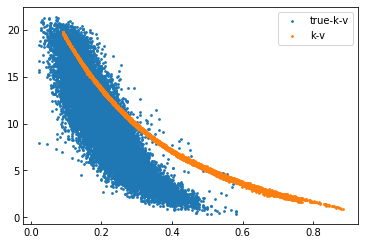

In [7]:
plt.scatter(flat_arrayrho,flat_arrayv,s=3,label='true-k-v')
plt.scatter(rho_pred,v_pred,s=3,label="k-v")

plt.legend()